In [1]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)


bs = 1024
@inplace
def transformi(b): b['image'] = [(torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) - x_mean) / x_std for o in b['image']]

tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

x_mean = xb.mean((1,2,3), keepdim=True)
x_std = xb.std((1,2,3), keepdim=True)


Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([3, 7, 8, 3, 2, 1, 0, 0, 0, 8]))

In [19]:
xb.mean(), xb.std()

(tensor(-0.0121), tensor(1.0061))

In [34]:
nn.Parameter(torch.tensor(1.))

Parameter containing:
tensor(1., requires_grad=True)

In [67]:
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np

class LayerNorm(nn.Module):
    def __init__(self):
        super().__init__()
#         y = a * x + b
        self.a = nn.Parameter(torch.tensor(1.))
        self.b = nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        mean = x.mean((1, 2, 3), keepdim=True)
        std = x.std((1, 2, 3), keepdim=True)
        x = (x - mean) / std
        x = self.a * x + self.b
        return x

class GeneralRelu(nn.Module):
    def __init__(self, leak=0.1, sub=0.4, maxv=2):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def conv(ni, nf, ks=3, stride=2, act=True, norm=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if norm: res = nn.Sequential(res, LayerNorm())
    if act: res = nn.Sequential(res, GeneralRelu())
    return res

def get_model():
    layers = [conv(1,8),            #14x14
    conv(8,16),            #7x7
    conv(16,32),           #4x4
    conv(32,64),           #2x2
    conv(64,10, act=False), #1x1
    nn.Flatten()]
    model = nn.Sequential(*layers)
    return model

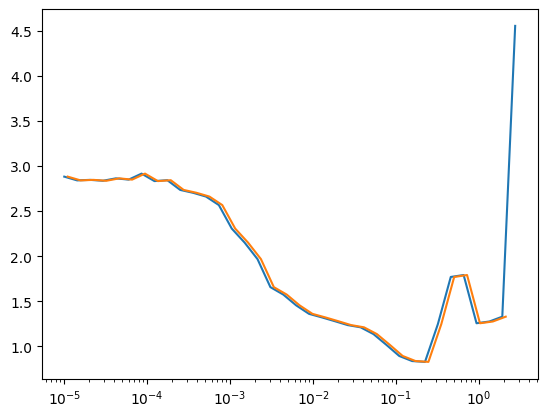

In [68]:
import miniai
from miniai.learner import MomentumLearner as Learner, DeviceCB, MetricsCB, ProgressCB, LRFinderCB
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy,Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), LRFinderCB(gamma=1.1), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.lr_find()

accuracy,loss,epoch,train
0.729,0.758,0,train
0.822,0.486,0,eval


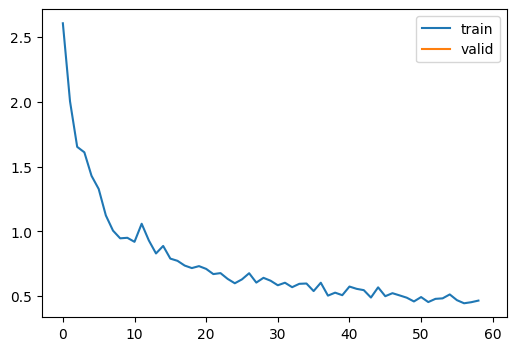

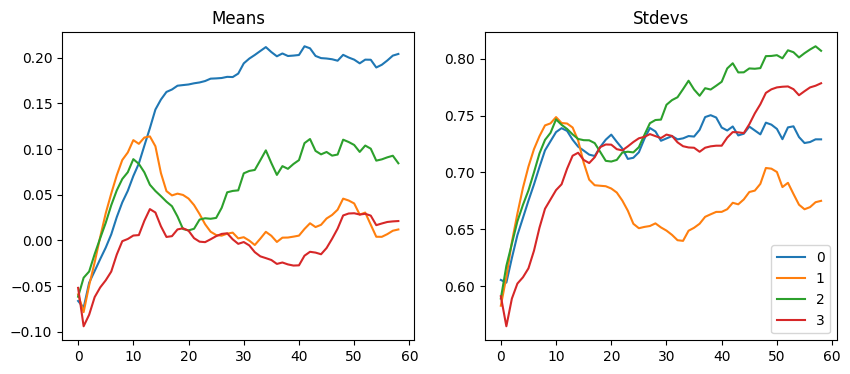

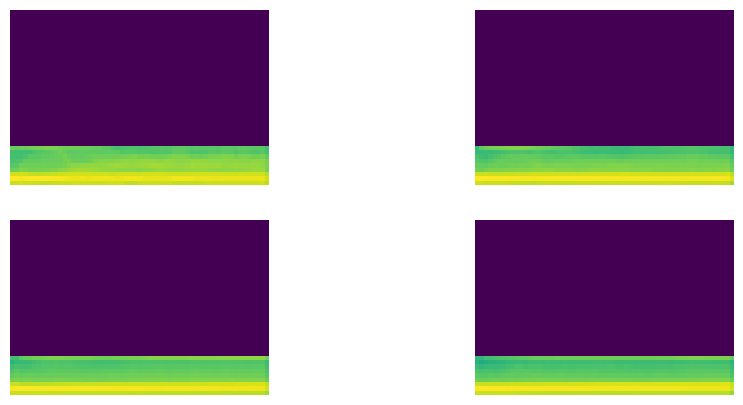

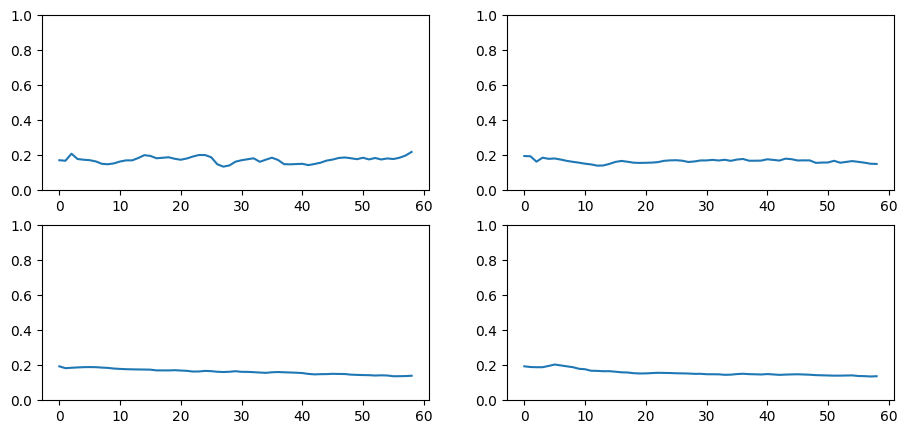

In [69]:
from miniai.activations import ActivationStats
import fastcore.all as fc

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2,cbs=cbs)
learn.fit(1)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

accuracy,loss,epoch,train
0.849,0.414,0,train
0.848,0.405,0,eval
0.873,0.347,1,train
0.864,0.382,1,eval
0.882,0.321,2,train
0.877,0.347,2,eval


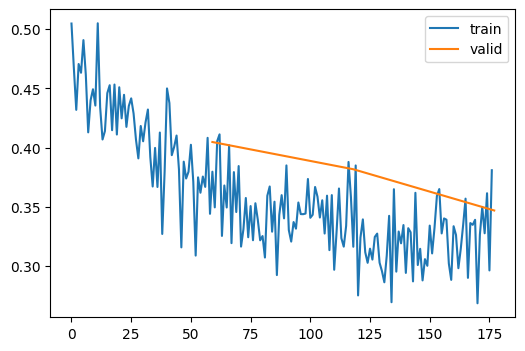

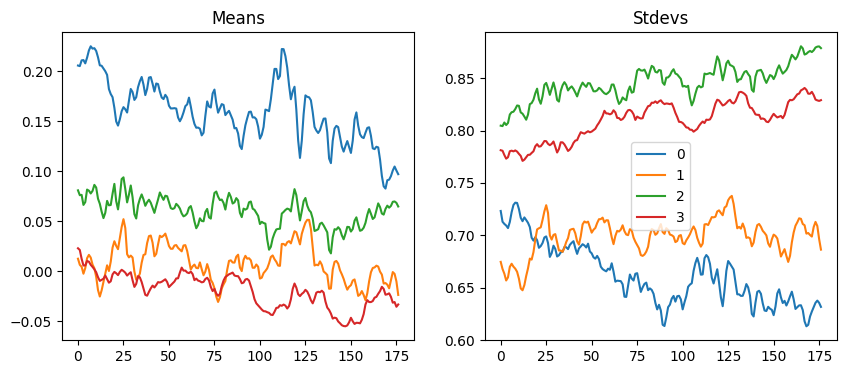

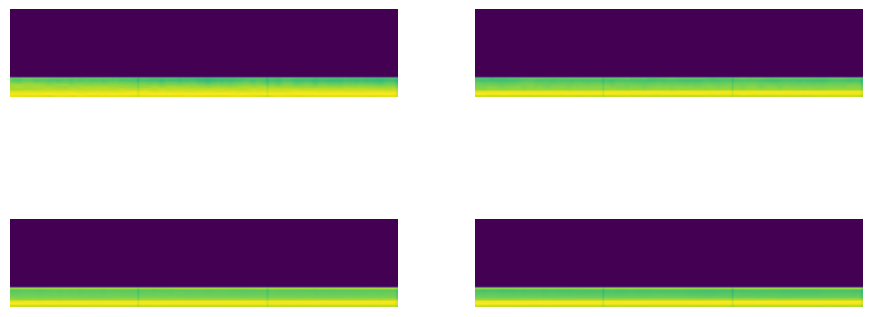

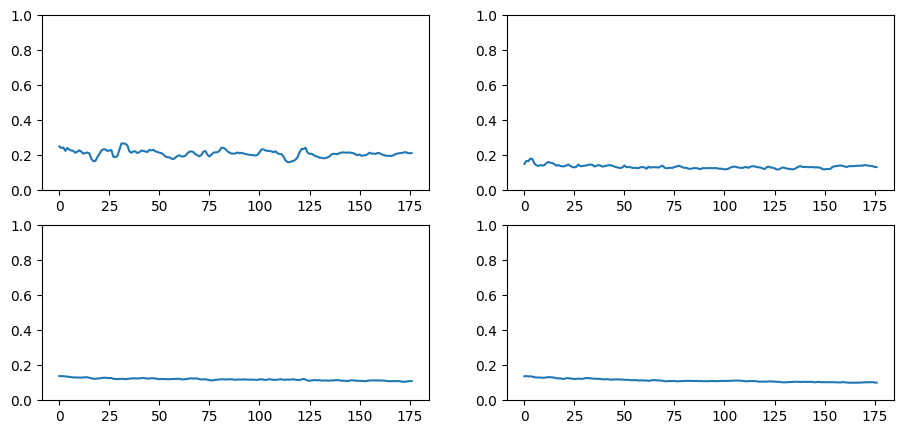

In [70]:
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()